# Milestone 3: Machine Learning

In [2]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
!pip install sagemaker_pyspark

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket() 
print(f"the default SageMaker region specific bucket for this account is {bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
the default SageMaker region specific bucket for this account is sagemaker-us-east-1-527047370587


In [4]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import lit
from pyspark.sql import Window
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [5]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4182547a-a54d-49fe-a829-bb718fe7a92e;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 

24/04/23 17:17:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/23 17:17:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, HashingTF, StopWordsRemover
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, MapType, StringType
import string
from sparknlp.pretrained import PretrainedPipeline
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, LemmatizerModel

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ML
### 9. Correlating Public and Media Sentiment Scores on Reddit with Stock Price Movements of Top Tech Companies 
In this segment of our analysis, we aim to understand the relationship between Reddit-derived sentiment scores and the stock price movements of the top five technology companies. We've identified the following variables: the daily average public sentiment from `r/Technology` and the average media sentiment from `r/News`. These metrics provide a nuanced view of the prevailing sentiments in technology discussions.
By leveraging these sentiment indicators, we would employ machine learning models to predict the stock price changes for the top 5 tech companies: Microsoft, Nvidia, Adobe, Alphabet, and Amazon. Our objective is to determine the degree to which shifts in public opinion and media coverage on Reddit correlate with and potentially influence the stock market performance of these tech giants. We would use Root Mean Square Error (RMSE) as a metric to assess our models' accuracy and predictive power. This analysis is designed to pinpoint which technology company's stock is most affected by the sentiment dynamics on Reddit, offering valuable insights into the interplay between online discourse and financial markets.

In [8]:
!pip install yfinance

  Using cached yfinance-0.2.38-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (23 kB)
  Using cached peewee-3.17.3-cp310-cp310-linux_x86_64.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached yfinance-0.2.38-py2.py3-none-any.whl (72 kB)
Using cached frozendict-2.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (116 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [12]:
import yfinance as yf

# Define the list of companies
companies = ['MSFT', 'NVDA', 'ADBE', 'GOOGL', 'AMZN']

# Fetch historical stock data for each company
start_date = '2021-01-01'
end_date = '2023-02-28'

stock_data = {}
for company in companies:
    stock_data[company] = yf.download(company, start=start_date, end=end_date)['Adj Close']

# Create a DataFrame to store the adjusted closing prices
df = pd.DataFrame(stock_data).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [13]:
df.head()

,Date,MSFT,NVDA,ADBE,GOOGL,AMZN
0,2021-01-04,211.605286,130.833954,485.339996,86.306503,159.331497
1,2021-01-05,211.809402,133.739777,485.690002,87.002502,160.925507
2,2021-01-06,206.317368,125.855408,466.309998,86.143997,156.919006
3,2021-01-07,212.188522,133.133713,477.739990,88.717003,158.108002
4,2021-01-08,213.481354,132.462738,485.100006,89.891502,159.134995


In [25]:
#import the sentiment score
tech = pd.read_csv("tech_sentiment_daily.csv")
news = pd.read_csv("news_sentiment_daily.csv")
df1 = pd.merge(tech,news,on='created_date',how='inner',suffixes=('_tech', '_news')).rename(columns={'created_date':"Date"})
df1.head()

,Date,chatgpt_sentiment_tech,aurora_sentiment_tech,bard_sentiment_tech,copilot_sentiment_tech,deepmind_sentiment_tech,drone_sentiment_tech,metaverse_sentiment_tech,mobileye_sentiment_tech,roomba_sentiment_tech,...,bard_sentiment_news,copilot_sentiment_news,deepmind_sentiment_news,drone_sentiment_news,metaverse_sentiment_news,mobileye_sentiment_news,roomba_sentiment_news,oculus_sentiment_news,waymo_sentiment_news,mean_sentiment_news
0,2021-01-01,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2021-01-02,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.090909
2,2021-01-03,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.090909
3,2021-01-04,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.181818
4,2021-01-06,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.000000


In [27]:
df1['Date'] = pd.to_datetime(df1['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df2 = pd.merge(df1,df,how='inner', on='Date')
df2.head()

,Date,chatgpt_sentiment_tech,aurora_sentiment_tech,bard_sentiment_tech,copilot_sentiment_tech,deepmind_sentiment_tech,drone_sentiment_tech,metaverse_sentiment_tech,mobileye_sentiment_tech,roomba_sentiment_tech,...,mobileye_sentiment_news,roomba_sentiment_news,oculus_sentiment_news,waymo_sentiment_news,mean_sentiment_news,MSFT,NVDA,ADBE,GOOGL,AMZN
0,2021-01-04,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.181818,211.605286,130.833954,485.339996,86.306503,159.331497
1,2021-01-06,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.0,0.000000,206.317368,125.855408,466.309998,86.143997,156.919006
2,2021-01-07,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.030303,212.188522,133.133713,477.739990,88.717003,158.108002
3,2021-01-08,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.090909,213.481354,132.462738,485.100006,89.891502,159.134995
4,2021-01-11,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.090909,211.410889,135.902313,474.239990,87.814499,155.710495


#### Model 1: Linear Regression Model

In [58]:
X = df2[df2.columns.to_list()[1:-5]]
y1 = df2['MSFT']
y2 = df2['NVDA']
y3 = df2['ADBE']
y4 = df2['GOOGL']
y5 = df2['AMZN']

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, train_size=0.7, random_state=2529)
_, _, y2_train, y2_test = train_test_split(X, y2, train_size=0.7, random_state=2529)
_, _, y3_train, y3_test = train_test_split(X, y3, train_size=0.7, random_state=2529)
_, _, y4_train, y4_test = train_test_split(X, y4, train_size=0.7, random_state=2529)
_, _, y5_train, y5_test = train_test_split(X, y5, train_size=0.7, random_state=2529)

In [60]:
# Function to train and evaluate
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)  # Set squared=False for RMSE
    return rmse

# Calculate RMSE for each target
rmse_y1 = train_and_evaluate(X_train, X_test, y1_train, y1_test)
rmse_y2 = train_and_evaluate(X_train, X_test, y2_train, y2_test)
rmse_y3 = train_and_evaluate(X_train, X_test, y3_train, y3_test)
rmse_y4 = train_and_evaluate(X_train, X_test, y4_train, y4_test)
rmse_y5 = train_and_evaluate(X_train, X_test, y5_train, y5_test)

print(f"RMSE for MSFT: {rmse_y1}")
print(f"RMSE for NVDA: {rmse_y2}")
print(f"RMSE for ADBE: {rmse_y3}")
print(f"RMSE for GOOGL: {rmse_y4}")
print(f"RMSE for AMZN: {rmse_y5}")

RMSE for MSFT: 28.795268507325442
RMSE for NVDA: 47.21344337187145
RMSE for ADBE: 103.42934293039589
RMSE for GOOGL: 16.72646346533192
RMSE for AMZN: 26.894737297245555


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

The analysis of the RMSE values reveals that the sentiment scores for individual technical products, derived from both technology and news-themed subreddits, are valuable predictors of stock prices. Notably, the mean sentiment scores across all products within these categories also demonstrate significant predictive power. The data suggests that these sentiment metrics are particularly effective for forecasting Google's stock price, as indicated by the lowest RMSE among the evaluated stocks. This finding underscores the utility of sentiment analysis from specialized online communities in predicting stock market movements, especially for tech-oriented companies like Google.

Then we delve into the Google to check the coefficients and try some regularization to make the model achieve its best performance.

In [67]:
from sklearn.linear_model import Ridge, Lasso
from scipy import stats

In [68]:
def train_and_evaluate_with_regularization(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)  # RMSE
    coefficients = model.coef_
    return rmse, coefficients

In [71]:
# Select the model and alpha (regularization strength)
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# Use the function to train and evaluate
rmse_ridge, coef_ridge = train_and_evaluate_with_regularization(ridge_model, X_train, X_test, y4_train, y4_test)
rmse_lasso, coef_lasso = train_and_evaluate_with_regularization(lasso_model, X_train, X_test, y4_train, y4_test)

print(f"RMSE (Ridge): {rmse_ridge}")
print(f"Coefficients (Ridge): {coef_ridge}")
print(f"RMSE (Lasso): {rmse_lasso}")
print(f"Coefficients (Lasso): {coef_lasso}")

RMSE (Ridge): 16.432223178021136
Coefficients (Ridge): [-13.08904682 -16.96772396  -5.81188648   9.69457962   0.8161821
  -0.33029967   0.93391915  -5.33917463  -3.87354191  -0.63191092
   8.82144252  -2.34340555  -9.41534913  -2.17020055  -0.3145927
   2.24204038  -9.04819519   2.0980212    2.54751867   7.42685616
   2.43692281  -5.07960825  10.13427104   0.07797131]
RMSE (Lasso): 16.234335968050186
Coefficients (Lasso): [-13.41211077  -0.04763079  -2.79396748   6.59125012   0.
  -0.48821629   0.21436249  -0.          -0.50253891  -0.
   6.73234394  -0.          -8.78076045  -0.          -0.
   0.          -1.83033288   2.12884025   2.28241148   0.
   0.          -0.           7.88535659  -0.        ]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


We can see the RMSE for Lasso is the lowest, which means some regularization is necessary. We then delve into Lasso(0.1) model.

                          Coefficients
chatgpt_sentiment_tech      -13.412111
aurora_sentiment_tech        -0.047631
bard_sentiment_tech          -2.793967
copilot_sentiment_tech        6.591250
deepmind_sentiment_tech       0.000000
drone_sentiment_tech         -0.488216
metaverse_sentiment_tech      0.214362
mobileye_sentiment_tech      -0.000000
roomba_sentiment_tech        -0.502539
oculus_sentiment_tech        -0.000000
waymo_sentiment_tech          6.732344
mean_sentiment_tech          -0.000000
chatgpt_sentiment_news       -8.780760
aurora_sentiment_news        -0.000000
bard_sentiment_news          -0.000000
copilot_sentiment_news        0.000000
deepmind_sentiment_news      -1.830333
drone_sentiment_news          2.128840
metaverse_sentiment_news      2.282411
mobileye_sentiment_news       0.000000
roomba_sentiment_news         0.000000
oculus_sentiment_news        -0.000000
waymo_sentiment_news          7.885357
mean_sentiment_news          -0.000000


<Figure size 1500x800 with 0 Axes>

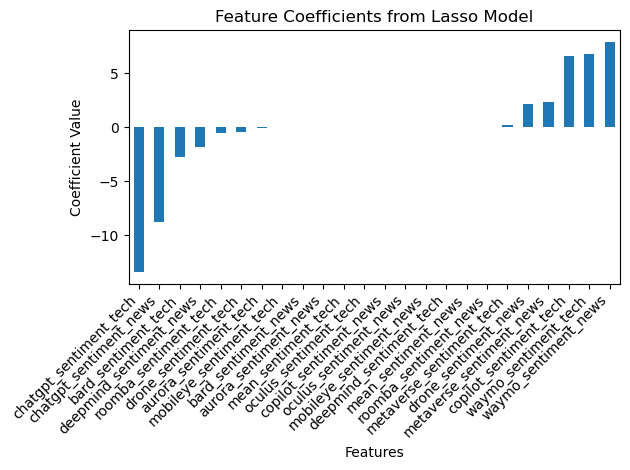

In [80]:
# Display the coefficients
coefficients = pd.DataFrame(data=lasso_model.coef_, index=X_train.columns, columns=['Coefficients'])
print(coefficients)

# Make sure that the index of 'coefficients' DataFrame is set to the feature names if it's not already
coefficients = coefficients.sort_values(by='Coefficients')  # Correcting the typo here

# Plotting the coefficients
plt.figure(figsize=(15, 8)) 
coefficients.plot(kind='bar', legend=False)  
plt.title('Feature Coefficients from Lasso Model')
plt.xlabel('Features')  
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

The plot reveals that certain sentiment scores, notably those related to the tech category for some products, have a pronounced negative effect, whereas others, particularly within the news category, exert a strong positive influence. The length of each bar signifies the strength of the feature's coefficient, with longer bars signifying greater importance in the model. Notably, the coefficients of some features have been shrunk towards zero, which is a characteristic effect of Lasso regularization, emphasizing features that contribute the most to predicting the target variable while discarding less relevant ones.

#### Model 2: Decision Tree and Random Forest Model

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


In [65]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)  # RMSE
    return rmse

In [63]:
targets = ['MSFT', 'NVDA', 'ADBE', 'GOOGL', 'AMZN']
X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}

# Splitting data
for target in targets:
    y = df2[target]
    X_train[target], X_test[target], y_train_dict[target], y_test_dict[target] = train_test_split(X, y, train_size=0.7, random_state=2529)

In [66]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=2529),
    'Decision Tree': DecisionTreeRegressor(random_state=2529)
}

# Storing results
results = {model_name: {} for model_name in models.keys()}

for model_name, model in models.items():
    for target in targets:
        rmse = train_and_evaluate(model,
                                  X_train[target], X_test[target],
                                  y_train_dict[target], y_test_dict[target])
        results[model_name][target] = rmse
        print(f"RMSE for {target} using {model_name}: {rmse}")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for MSFT using Random Forest: 26.99915359404366


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for NVDA using Random Forest: 49.26399609109699


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for ADBE using Random Forest: 98.67131575040078


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for GOOGL using Random Forest: 16.092053336631185
RMSE for AMZN using Random Forest: 25.37289105638457
RMSE for MSFT using Decision Tree: 34.30098205448226
RMSE for NVDA using Decision Tree: 65.46437379199376
RMSE for ADBE using Decision Tree: 122.14134727421417
RMSE for GOOGL using Decision Tree: 20.53803847214092
RMSE for AMZN using Decision Tree: 30.853703299463344


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

The analysis of RMSE values clearly indicates that the Random Forest model outperforms the Decision Tree model, particularly in predicting Google's stock price, as evidenced by its lower RMSE. Additionally, the Random Forest model shows a slight edge over the Lasso model in terms of predictive accuracy. Given these results, it would be prudent to further investigate the Random Forest model to understand its effectiveness better. By examining the feature importance metrics within this model, we can identify which variables most significantly impact Google's stock price, providing valuable insights for future modeling and decision-making processes.

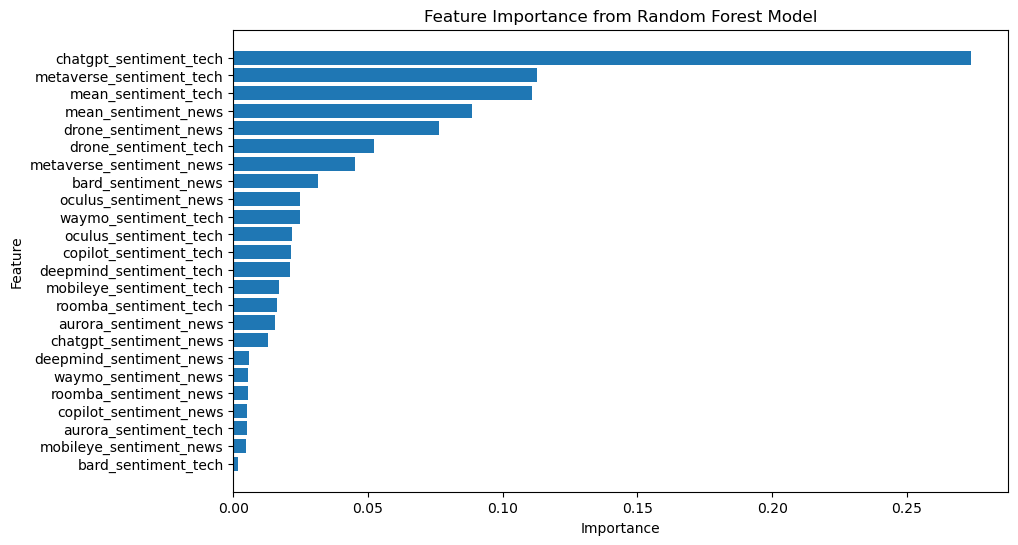

In [81]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=2529)
random_forest.fit(X_train, y4_train)
feature_importances = random_forest.feature_importances_
# Creating a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In this case, 'chatgpt_sentiment_tech' appears to be the most influential feature, with the highest importance score, suggesting it has the strongest relationship with the model’s output variable. The features 'metaverse_sentiment_tech', 'mean_sentiment_tech', and 'mean_sentiment_news' follow as the next most significant. On the other hand, 'bard_sentiment_tech' has the lowest importance score, indicating it has the least influence on the model's predictions.

### 10.  Classifying post origins between `r/Technology` and `r/News`?

We plan to use a variety of classifier models to determine whether a post originates from `r/Technology`, which reflects public opinion, or `r/News`, which represents media opinion. Our analysis will leverage various features from the dataset, with a particular focus on the textual content of the posts. We aim to identify and understand the distinctive features and language used in each subreddit's discussions.
This will test the accuracy of our classification models and aims to reveal the unique textual elements that differentiate public-driven discussions in `r/Technology` from media-oriented narratives in `r/News`. By pinpointing these distinguishing features, we hope to gain a deeper insight into the content and communication styles in each subreddit, enhancing our understanding of how different audiences engage with technology-related topics.

In [82]:
%%time
news_submissions = spark.read.parquet("filter_news_sub.parquet", header=True)
technology_submissions = spark.read.parquet("filter_tech_sub.parquet", header=True)

CPU times: user 0 ns, sys: 6.06 ms, total: 6.06 ms
Wall time: 1.05 s


In [83]:
news_submissions.count()

4176

In [84]:
technology_submissions.count()

8497

In [89]:
news_submissions = news_submissions.withColumn("subreddit", lit("news"))
technology_submissions = technology_submissions.withColumn("subreddit", lit("technology"))

In [90]:
# Select 3000 samples from each submission set
df_news_sampled = news_submissions.sample(fraction=3000/4176, seed=999).orderBy(F.rand()).limit(3000)
df_tech_sampled = technology_submissions.sample(fraction=3000/8497, seed=999).orderBy(F.rand()).limit(3000)

In [91]:
df = df_news_sampled.union(df_tech_sampled)
df.count()

6000

In [92]:
# Create a binary label column based on subreddit
df = df.withColumn("label", F.when(F.col("subreddit") == "news", 1).otherwise(0))

In [98]:
df.show(5)

+------------+--------------------+--------------------+---------+-----+
|created_date|         final_words|      final_sentence|subreddit|label|
+------------+--------------------+--------------------+---------+-----+
|  2022-05-24|[goggle, deepmind...|goggle deepmind g...|     news|    1|
|  2022-10-10|[ai, model, draw,...| ai model draw image|     news|    1|
|  2021-06-10|[robotic, prosthe...|robotic prostheti...|     news|    1|
|  2021-08-03|[improve, digital...|improve digital e...|     news|    1|
|  2022-05-16|[state, art, ai, ...|state art ai imag...|     news|    1|
+------------+--------------------+--------------------+---------+-----+
only showing top 5 rows



#### Create CountVectorizer and Assembler, split data into Train/Test

In [99]:
cv = CountVectorizer(inputCol="final_words", outputCol="words_vec")
# Fit the transformer to the data
cv_model = cv.fit(df)

# Transform the data
df = cv_model.transform(df)

In [100]:
# Split the data into training and test sets
(train, test) = df.randomSplit([0.75, 0.25], seed=999)

In [103]:
# Assemble the features into a vector
assembler = VectorAssembler(inputCols=["words_vec"], outputCol="features")
train_data = assembler.transform(train)
test_data = assembler.transform(test)

#### Model 1: Logistic Regression Model

In [107]:
# Create a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

# Fit the model on the training data
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

l_fpr, l_tpr, l_thresholds = roc_curve(predictions.select("label").collect(), predictions.select("probability").rdd.map(lambda x: x[0][1]).collect())
l_roc_auc = auc(l_fpr, l_tpr)

In [108]:
print("Logistic Regression Accuracy = %g" % accuracy)

Logistic Regression Accuracy = 0.680344


#### Model 2: Random Forest Model

In [109]:
# Create a random forest classifier model
rf = RandomForestClassifier(numTrees=10, maxDepth=5)

# Fit the model on the training data
model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using ROC AUC
rf_fpr, rf_tpr, thresholds = roc_curve(predictions.select("label").collect(), predictions.select("probability").rdd.map(lambda x: x[0][1]).collect())
rf_roc_auc = auc(rf_fpr, rf_tpr)

24/04/23 18:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB


24/04/23 18:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1041.6 KiB
24/04/23 18:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
24/04/23 18:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1055.6 KiB
24/04/23 18:55:13 WARN DAGScheduler: Broadcasting large task binary with size 1063.2 KiB


In [110]:
# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.6730641958967571


#### Model 3: Naive Bayes Model

In [111]:
# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
nb_model = nb.fit(train_data)

# select example rows to display.
predictions = nb_model.transform(test_data)

# Evaluate the model using ROC AUC
nb_fpr, nb_tpr, thresholds = roc_curve(predictions.select("label").collect(), predictions.select("probability").rdd.map(lambda x: x[0][1]).collect())
nb_roc_auc = auc(nb_fpr, nb_tpr)

In [112]:
# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
# Print the accuracy
print("Naive Bayes Accuracy: {:.2f}%".format(accuracy*100))

Naive Bayes Accuracy: 74.72%


#### Plot ROC-AUC to evaluate model results

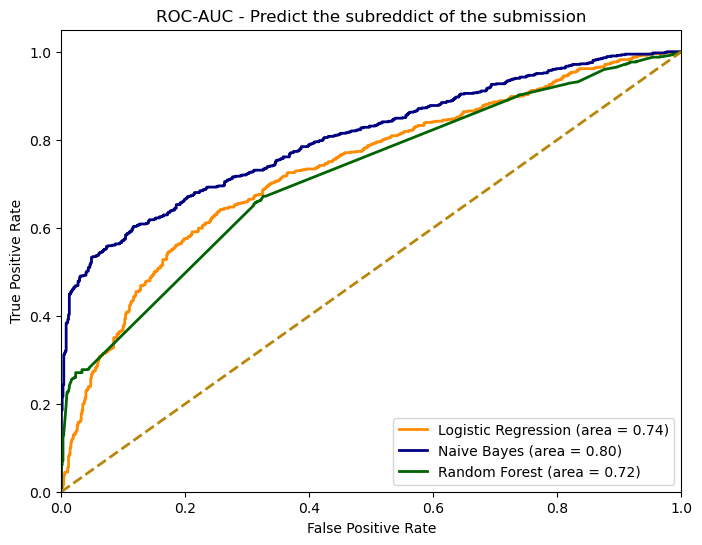

In [113]:
# Create a plot of the ROC curve
plt.figure(figsize=(8,6))
lw = 2
plt.plot(l_fpr, l_tpr, color='darkorange', lw=lw, label='Logistic Regression (area = %0.2f)' % l_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='navy', lw=lw, label='Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='darkgreen', lw=lw, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='darkgoldenrod', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC - Predict the subreddict of the submission')
plt.legend(loc="lower right")
plt.show()